# Benchmarks

In [6]:
import pandas as pd

results = pd.read_csv('results.csv').dropna()

results

,struct_name,precision,bits,memory_requirements,population_time,cardinality_time,cardinality,cardinality_squared_error
0,HyperLogLog,4,1,8,80527466,7675,18,26897852906596
1,HyperLogLog,4,2,8,68910916,5088,86,26897147572516
2,HyperLogLog,4,3,12,73582145,5800,1378,26883747982116
3,HyperLogLog,4,4,12,67935050,342,352845,23362596579169
4,HyperLogLog,4,5,16,73404591,5438,6394940,1460733297664
...,...,...,...,...,...,...,...,...
8103,HyperLogLog,11,4,1028,58648534,1161,4780359,13722951025
8104,HyperLogLog,11,5,1372,63562538,1167,4802479,19394740225
8105,HyperLogLog,11,6,1644,62175577,1183,4802479,19394740225
8106,HyperLogLog,12,1,516,55349126,2432,4815,21700681243201


In [7]:
from tqdm.auto import tqdm
import numpy as np

tasks = [
    column.replace("_squared_error", "")
    for column in results.columns
    if "squared_error" in column
]

rates = []

for task in tqdm(tasks, desc="Computing rates", leave=False):
    for precision in tqdm(results.precision.unique(), desc=f"Precision", leave=False):
        if precision == 0:
            continue
        reference = results[
            (results.precision == precision) &
            (results.bits == 6)
        ]
        for bits in results.bits.unique():
            if bits == 0:
                continue
            this_struct = results[
                (results.precision == precision) &
                (results.bits == bits)
            ]
            for column in [f"{task}_squared_error", f"{task}_time", "memory_requirements"]:
                rate = this_struct[column].mean() / reference[column].mean()
                assert np.isfinite(rate), (
                    f"Rate is not finite for task {task}, precision {precision}, "
                    f"bits {bits}, column {column}. The reference value is "
                    f"{reference[column].mean()}. The value is {this_struct[column].mean()}."
                )
                rates.append({
                    "task": task,
                    "precision": precision,
                    "bits": bits,
                    "column": column,
                    "rate": rate
                })

rates = pd.DataFrame(rates)
rates

Computing rates:   0%|          | 0/1 [00:00<?, ?it/s]

Precision:   0%|          | 0/14 [00:00<?, ?it/s]

,task,precision,bits,column,rate
0,cardinality,4,1,cardinality_squared_error,21.016154
1,cardinality,4,1,cardinality_time,1.774326
2,cardinality,4,1,memory_requirements,0.400000
3,cardinality,4,2,cardinality_squared_error,21.015511
4,cardinality,4,2,cardinality_time,1.001356
...,...,...,...,...,...
229,cardinality,16,5,cardinality_time,1.024340
230,cardinality,16,5,memory_requirements,0.833321
231,cardinality,16,6,cardinality_squared_error,1.000000
232,cardinality,16,6,cardinality_time,1.000000


Plotting:   0%|          | 0/3 [00:00<?, ?it/s]

/var/folders/22/8r87klw91pj7r5jzplv2bcsc0000gn/T/ipykernel_48277/1914057914.py:4: PerformanceWarning: indexing past lexsort depth may impact performance.
  df2["precision_float"] = df2.reset_index()[("precision",)].astype(float).astype(int).values
/var/folders/22/8r87klw91pj7r5jzplv2bcsc0000gn/T/ipykernel_48277/1914057914.py:5: PerformanceWarning: indexing past lexsort depth may impact performance.
  df2["bits_float"] = df2.reset_index()[("bits",)].astype(float).astype(int).values
/Users/lucacappelletti/opt/miniconda3/envs/py38/lib/python3.8/site-packages/barplots/barplot.py:375: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax.set_ylim(min_length, max_length)
/var/folders/22/8r87klw91pj7r5jzplv2bcsc0000gn/T/ipykernel_48277/1914057914.py:4: PerformanceWarning: indexing past lexsort depth may impact performance.
  df2["precision_float"] = df2.reset_index()[("precision",)].astype(float).astype(int).values
/var/folders/22/8r87klw91pj7r5jzplv2bcsc000

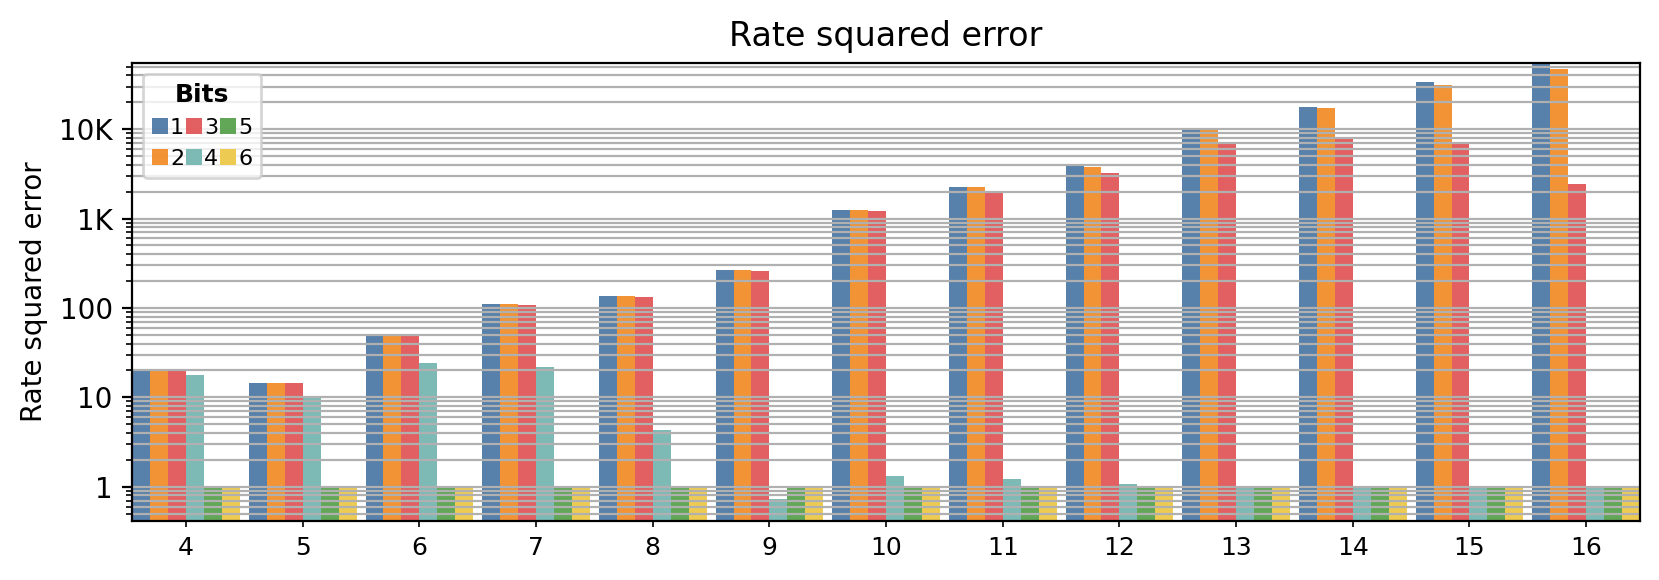

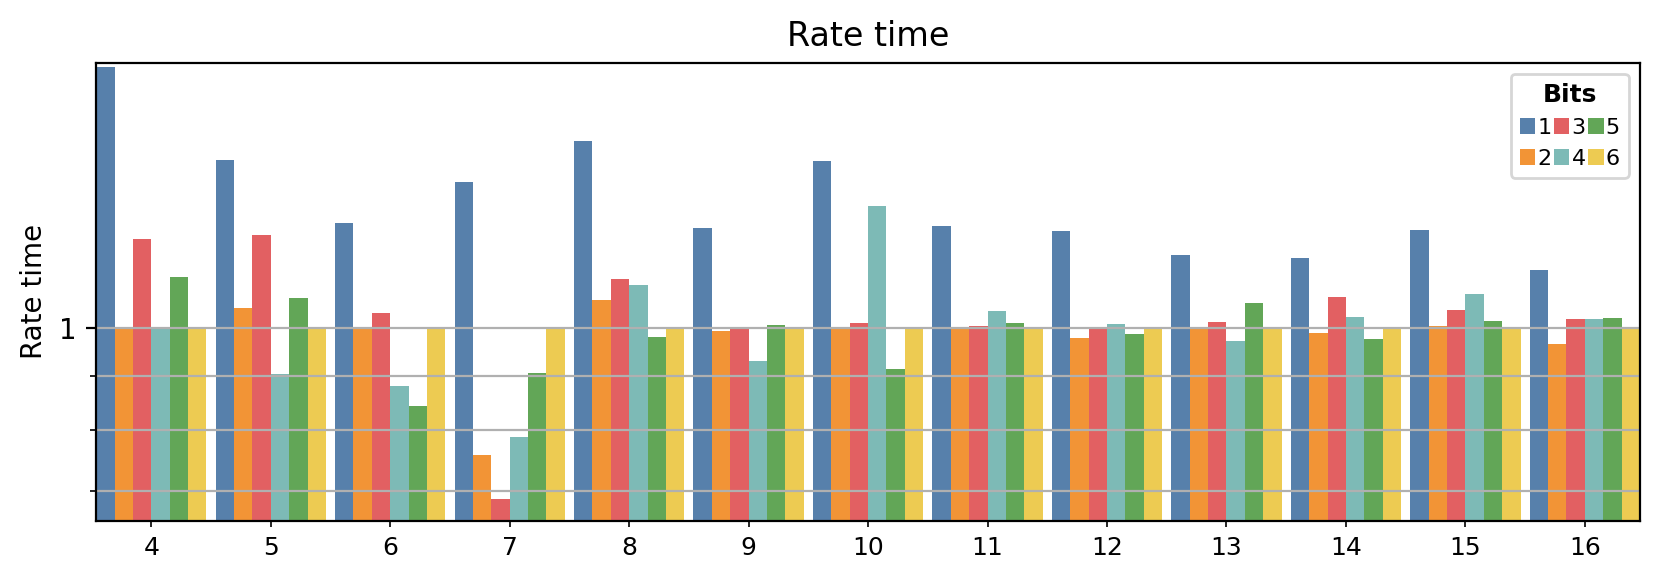

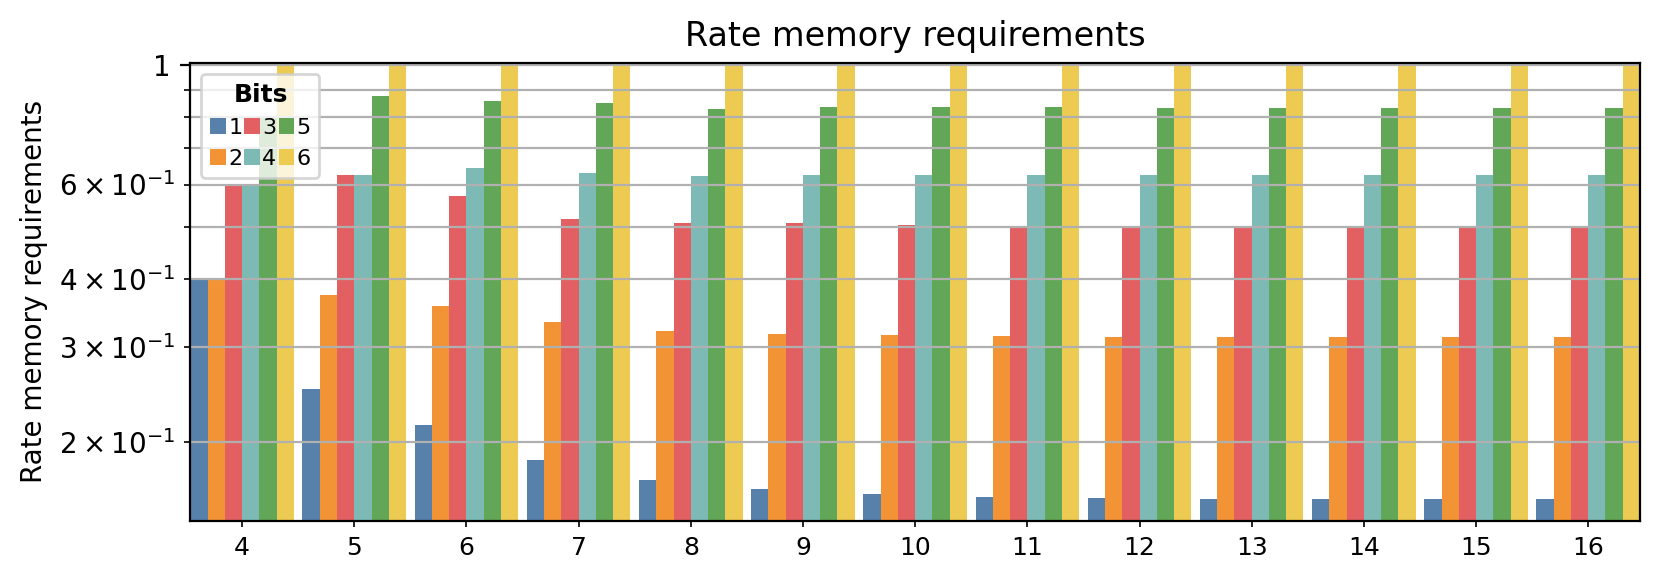

In [12]:
from barplots import barplots

def sort_by_precision(df2):
    df2["precision_float"] = df2.reset_index()[("precision",)].astype(float).astype(int).values
    df2["bits_float"] = df2.reset_index()[("bits",)].astype(float).astype(int).values
    return df2.sort_values(["precision_float", "bits_float"]).drop(columns=["precision_float", "bits_float"])

for tag in tqdm(("squared_error", "time", "memory_requirements"), desc="Plotting", leave=False):
    rates[f"rate_{tag}"] = rates["rate"]
    _ = barplots(
        rates[rates["column"].str.contains(tag)][["task", "precision", "bits", f"rate_{tag}"]],
        groupby=["task", "precision", "bits"],
        subplots=True,
        bar_width=0.1,
        space_width=0.05,
        unique_minor_labels=False,
        unique_major_labels=False,
        sort_bars=sort_by_precision,
        minor_rotation=0,
        plots_per_row=3,
        height=3,
        ncol=3,
        scale="log"
    )